In [53]:
def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt



In [54]:
def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width



In [416]:
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):

#     #Create a model
#     import cmath
# #     import pyomo.environ as pyo
#     from pyomo.opt import SolverFactory
#     from pyomo.environ import *
#     #from pyomo.environ import sin, cos
    base = 100
    model = ConcreteModel()
#     model.IDX2 = range(bus_len)
    model.t = Var(range(bus_len))

    model.vars = Var(range(len(fva)))
#     model.vars[primary_var].setlb(primary_lb)
#     model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        model.c = ConstraintList()
        
        #Bus voltage angle initial condition
        model.c.add(model.t[0] == 0)

        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2
        
        #Limits constraints
        for i in range(gen_len):
            model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
            model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
            model.c.add(expr = model.vars[i+5] <= fva.iloc[i+5]['maximum'])
            model.c.add(expr = model.vars[i+5] >= fva.iloc[i+5]['minimum'])
        for i in range(bus_len):    
            model.c.add(expr = model.vars[i+10] <= fva.iloc[i+10]['maximum'])
            model.c.add(expr = model.vars[i+10] >= fva.iloc[i+10]['minimum'])
        
        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+5]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.vars[i+10]*model.vars[j+10]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 + Pd[i]== 0)
            model.c.add(expr = sum([model.vars[i+10]*model.vars[j+10]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 + Qd[i]== 0)

        #Line flow constraints
        
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/base)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.vars[x+10]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.vars[x+10]*model.vars[y+10]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.vars[x+10]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.vars[x+10]*model.vars[y+10]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.vars[y+10]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.vars[x+10]*model.vars[y+10]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.vars[y+10]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.vars[x+10]*model.vars[y+10]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 0)

    solution = SolverFactory('ipopt').solve(model)
    
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
#         model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
#         model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return np.array([model.vars[i].value for i in range(len(fva))])
    
    elif (solution.solver.status == SolverStatus.error):
        # Do something when model in infeasible
#         model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
#         model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None
    
    elif (solution.solver.termination_condition == TerminationCondition.infeasible):
        # Do something when model in infeasible
#         model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
#         model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None
    else:
        # Something else is wrong
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None
        
#     if str(solution['Solver'].Termination_condition) != 'optimal':
#         return None
#     else:
#         result_v = np.array([model.vars[i].value for i in range(len(fva))])
# #         result_t = np.array([model.t[i].value for i in range(bus_len)])
        
    
#     return result_v#, result_t


In [417]:
import time
import numpy as np
import pandas as pd

#load data
xls = pd.ExcelFile('data\case14.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')
base = 100  

#Y matrix
base = 100
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len):  
    x[i] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)


# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2
# 
p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P1','P2','P3','P4','P5']
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q1','Q2','Q3','Q4','Q5']
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V1','V2','V3','V4','V5','V6','V7',
             'V8','V9','V10','V11','V12','V13','V14']
v = v.T

frames = [p,q,v]
fva = pd.concat(frames)


def gapsplit(
        n, max_tries = None,
        primary='sequential', primary_tol=0.001,
        secondary_frac=0.05,
        min_range=1e-5,
        enforce_range=True,
        report_interval=0.1,
        quiet=False):
    
    if quiet:
        report = lambda s: None
    else:
        report = lambda s: print(s)
  

    if secondary_frac >= 1.0:
        n_secondary = secondary_frac
    else:
        n_secondary = np.floor(secondary_frac * len(fva)).astype(int)

    # only split reactions with feasible range >= min_range
    idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
    weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
    report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
    report("Targeting {} secondary variables.".format(n_secondary))

    report_header, report_format = _make_report_header(n)
    report("\n" + report_header)
    if report_interval < 1.0:
        report_interval = np.floor(report_interval * n).astype(int)
    samples = np.zeros((n, len(fva)))
#     angles = np.zeros((n,bus_len))

    k = 0
    infeasible_count = 0

#     primary_var = -1
    try_ = 0
    start_time = time.time()
    
    while True:
        if max_tries is not None and try_ >= max_tries:
            break
        try_ += 1
        relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
        primary_var = np.argmax(relative)
#         primary_var += 1
#         if primary_var >= len(idxs):
#             primary_var = 0

        primary_target = target[primary_var]
        primary_lb = primary_target - primary_tol*width[primary_var]
        primary_ub = primary_target + primary_tol*width[primary_var]
        secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
        secondary_targets = target[secondary_vars]
        secondary_weights = weights[idxs[secondary_vars]]

        #model = pyo.ConcreteModel()
        new_sample =  _generate_sample(
                    idxs[primary_var], primary_lb, primary_ub,
                    idxs[secondary_vars], secondary_targets, secondary_weights)


        if new_sample is not None:
            if enforce_range:
                new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
                new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

            samples[k,:] = new_sample
#             angles[k,:] = angles_
            k += 1
            if k % report_interval == 0:
                elapsed = time.time() - start_time
                remaining = elapsed / k * (n - k)
                report(report_format.format(
                        i=k, n=n, cov=100*(1-np.mean(relative)),
                        min=np.min(relative), med=np.median(relative),
                        max=np.max(relative), ela=elapsed, rem=remaining,
                        inf=infeasible_count))
        else:
            infeasible_count += 1

        if k >= n: break
    
    if k < n:
        # max_tries reached; return fewer than n samples
        samples = samples[:k,:]
#         angles = angles[:k,:]

    return pd.DataFrame(data=samples,columns=fva.maximum.index)

In [418]:
ans = gapsplit(8,secondary_frac=0.05)

Targeting 24/24 unblocked primary variables.
Targeting 1 secondary variables.

Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
   1/8      0.00%   1.0000   1.0000   1.0000        0.22          1.54            0


C:\Users\abuga\Anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: divide by zero encountered in long_scalars


   2/8     31.67%   0.5000   0.6141   0.9431        0.39          1.18            0
   3/8     44.43%   0.3872   0.5539   0.8060        0.56          0.94            0
   4/8     46.92%   0.3518   0.4962   0.8060        0.75          0.75            0
   5/8     49.02%   0.3154   0.4803   0.8060        0.96          0.57            0
   6/8     54.16%   0.2566   0.4428   0.8060        1.14          0.38            0
   7/8     54.37%   0.2112   0.4428   0.8060        1.35          0.19            0
   8/8     55.49%   0.2112   0.4199   0.8060        1.54          0.00            0


In [423]:
new_sample[new_sample > fva.maximum]

array([], dtype=float64)

In [325]:
min_range = 1e-5
secondary_frac=0.75
report = lambda s: print(s)
n = 10
k = 4 

p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P1','P2','P3','P4','P5']
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q1','Q2','Q3','Q4','Q5']
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V1','V2','V3','V4','V5','V6','V7',
             'V8','V9','V10','V11','V12','V13','V14']
v = v.T

frames = [p,q,v]
fva = pd.concat(frames)

n_secondary = np.floor(secondary_frac * len(fva)).astype(int)

idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()

report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)

samples = np.zeros((n, len(fva)))

relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])

primary_tol=0.001
primary_var = 0
primary_target = target[primary_var]
primary_lb = primary_target - primary_tol*width[primary_var]
primary_ub = primary_target + primary_tol*width[primary_var]
secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
secondary_targets = target[secondary_vars]
secondary_weights = weights[idxs[secondary_vars]]

# model = pyo.ConcreteModel()

d =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)

Targeting 24/24 unblocked primary variables.
Targeting 18 secondary variables.

Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible


In [ ]:
for k in range(len(ans)):
    print(np.all([
        np.all([ans.loc[k][i] <= gen['Pmax'][i]/base for i in range(5)]) ,
        np.all([ans.loc[k][i] >= gen['Pmin'][i]/base for i in range(5)]) ,
        np.all([ans.loc[k][i+5] <= gen['Qmax'][i]/base for i in range(5)]) ,
        np.all([ans.loc[k][i+5] >= gen['Qmin'][i]/base for i in range(5)]) ,
        np.all([ans.loc[k][i+10] <= bus['Vmax'][i] for i in range(14)]) ,
        np.all([ans.loc[k][i+10] >= bus['Vmin'][i] for i in range(14)]) ,

        ]))

In [ ]:
for k in range(len(branch)): 
    x = int(branch.loc[k]['fbus'])-1
    y = int(branch.loc[k]['tbus'])-1
    val = (branch.loc[k]['rateA'])/base
    if val == 0:
        val = 10
    abs((((vv[x])**2)*cmath.polar(Ybus[x,y])[0])*np.cos(cmath.polar(Ybus[x,y])[1]) - (vv[x])*(vv[y])*cmath.polar(Ybus[x,y])[0]*np.cos((tt[x])-(tt[y])-cmath.polar(Ybus[x,y])[1]))<= val

#Check active/reactive power balance
for k in range(bus_len):
    p2[k] = sum([(vv[k])*(vv[j])*cmath.polar(Ybus[k,j])[0]*np.cos((tt[k])-(tt[j])-cmath.polar(Ybus[k,j])[1]) for j in range(bus_len)]) - pv[k] + Pd[k] <=0.001
    p3[k] = sum([(vv[k])*(vv[j])*cmath.polar(Ybus[k,j])[0]*np.sin((tt[k])-(tt[j])-cmath.polar(Ybus[k,j])[1]) for j in range(bus_len)]) - qv[k] + Qd[k] <=0.001

prop1 = np.all(p1)
prop2 = np.all(p2)
prop3 = np.all(p3)

prop[i] = prop1 & prop2 & prop3
if(prop[i]):
    counter = counter + 1

In [ ]:
vv = np.zeros(bus_len)
p = np.zeros(bus_len)
q = np.zeros(bus_len)
tt = np.zeros(bus_len)

for i in range(gen_len):
    p[gen['bus'][i]-1] = d[i]
    q[gen['bus'][i]-1] = d[i+5]
for i in range(bus_len):
    tt[i] = e[i]
    vv[i] = d[10+i]

for k in range(len(branch)): 
    x = int(branch.loc[k]['fbus'])-1
    y = int(branch.loc[k]['tbus'])-1
    val = (branch.loc[k]['rateA'])/base
    if val == 0:
        val = 10
    print(abs((((vv[x])**2)*cmath.polar(Ybus[x,y])[0])*np.cos(cmath.polar(Ybus[x,y])[1]) - (vv[x])*(vv[y])*cmath.polar(Ybus[x,y])[0]*np.cos((tt[x])-(tt[y])-cmath.polar(Ybus[x,y])[1])) <= val)


In [ ]:
for k in range(bus_len):
    print(sum([(vv[k])*(vv[j])*cmath.polar(Ybus[k,j])[0]*np.cos((tt[k])-(tt[j])-cmath.polar(Ybus[k,j])[1]) for j in range(bus_len)]) - p[k] + Pd[k] <= 0.0001)
    print(sum([(vv[k])*(vv[j])*cmath.polar(Ybus[k,j])[0]*np.sin((tt[k])-(tt[j])-cmath.polar(Ybus[k,j])[1]) for j in range(bus_len)]) - q[k] + Qd[k] <= 0.0001)


In [30]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

# # points = np.array([[0, 0, 0], [0, 1, 1], [0, 2, 2], [1, 0, 0], [1, 1, 1], [1, 2, 2],
#                   [2, 0, 0], [2, 1, 1], [2, 2, 2]])
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                  [2, 0], [2, 1], [2, 2]])
vor = Voronoi(points)

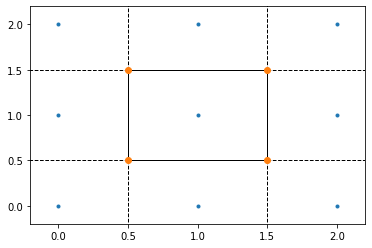

In [31]:
>>> import matplotlib.pyplot as plt
>>> voronoi_plot_2d(vor)
>>> plt.show()

In [52]:
vor.regions

[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [0, 1, 3, 2],
 [2, -1, 0],
 [3, -1, 1]]

In [51]:
points

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [36]:
vorm = Voronoi(m)
# vorm.point_region